# **CIFAR-10 image classification**

### Load, pre-process and explore data

In [1]:
# Import libraries
import json 
from pprint import pprint
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

In [2]:
# Define transformation
transform_train_0 = transforms.Compose([
    transforms.ToTensor(),
]) # basic trasformation

transform_train_1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
]) # transformation with normalization

transform_train_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.ColorJitter(),
]) # transformation with normalization & augmentation

transform_train_3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.ColorJitter(),
]) # transformation with augmentation

transform_val_0 = transforms.Compose([transforms.ToTensor(),
                                     ])

transform_val_1 = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
                                     ])
# Define batch size
batch_size=32

# Load data
trainset_0 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_0)
train_dataloader_0 = torch.utils.data.DataLoader(trainset_0, batch_size=batch_size , shuffle=True)

trainset_1 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_1)
train_dataloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size , shuffle=True)

trainset_2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_2)
train_dataloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=batch_size , shuffle=True)

trainset_3 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_3)
train_dataloader_3 = torch.utils.data.DataLoader(trainset_3, batch_size=batch_size , shuffle=True)

valset_0 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_0)
val_dataloader_0 = torch.utils.data.DataLoader(valset_0, batch_size= batch_size, shuffle=False)

valset_1 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_1)
val_dataloader_1 = torch.utils.data.DataLoader(valset_1, batch_size= batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Check shape
print("train data shape:", trainset_0.data.shape)
print("test data shape:",valset_0.data.shape)

train data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [4]:
# Label dictionary
label_dict = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

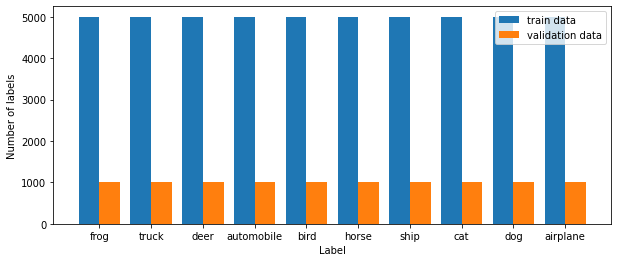

In [5]:
# Label distribution
c_train = Counter(trainset_0.targets)
c_val = Counter(valset_0.targets)
X = [label_dict[k] for k in c_train.keys()]
X_axis = np.arange(len(X))
plt.figure(figsize=(10,4))
plt.bar(X_axis - 0.2, c_train.values(), 0.4, label = 'train data')
plt.bar(X_axis + 0.2, c_val.values(), 0.4, label = 'validation data')
plt.xticks(X_axis, X)
plt.xlabel("Label")
plt.ylabel("Number of labels")
plt.legend()
plt.show()

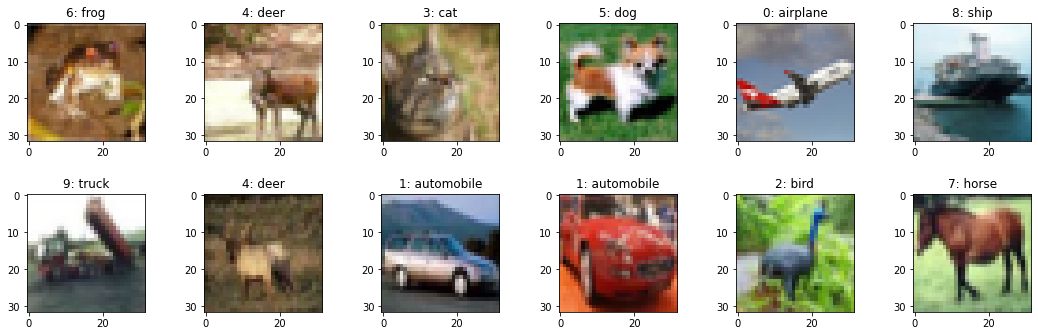

In [6]:
# Plot random images
image_idx = [0,1001,3550,12310,31674,42763,2,3,4,5,6,7]
fig = plt.figure(figsize=(18,6))
fig.subplots_adjust(hspace=0.1, wspace=0.5)

for i in range(len(image_idx)):
  img_index = image_idx[i]
  # Load image at index img_index
  rgb_img = trainset_0.data[img_index]
  rgb_img = rgb_img.astype('float32')    
  rgb_img/= 255.0

  # Plot
  ax = fig.add_subplot(2, 6, i+1)
  ax = plt.imshow(rgb_img)
  ax = plt.title(f'{trainset_0.targets[img_index]}: {label_dict[trainset_0.targets[img_index]]}')

### Set up GPU & functions

In [7]:
# Connect to drive to save models
from google.colab import drive
drive.mount('/content/gdrive')
!pwd

Mounted at /content/gdrive
/content


In [8]:
# Set up GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using {device}.")
if gpu_info.find('failed') >= 0:
  if device == "cpu":
    print('Not connected to a GPU')
else:
  if device == "cuda":
    print(gpu_info)

Using cuda.
Sun Feb  5 10:10:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

In [9]:
def train_validate_model(train_loader,valid_loader,model,epochs,optimizer, save_pth):
  '''
  Input: train & validation data, model and its parameters, path to save model
  Output: - the model is trained and validated on the provided data
          - training & validation accuracy & loss are recorded and returned as output
  '''
  train_acc = []
  train_loss = []
  val_acc = []
  val_loss = []

  for epoch in range(epochs):
      # Training
      total_train=0
      correct_train = 0
      for i, (images, labels) in enumerate(train_loader):  
          # Move tensors to the configured device
          images = images.to(device)
          labels = labels.to(device)
          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # Calculate train accuracy
          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()
          del images, labels, outputs
      # Record accuracy & loss
      train_loss.append(loss.item())
      train_acc.append(100 * correct_train / total_train)
      print ('Epoch [{}/{}], Training loss: {:.4f}, Train accuracy: {}' 
                   .format(epoch+1, epochs, loss.item(),100 * correct_train / total_train))
            
      # Validation
      with torch.no_grad():
          correct_val = 0
          total_val = 0
          for images, labels in valid_loader:
              # Move tensors to the configured device
              images = images.to(device)
              labels = labels.to(device)
              # Predict label
              outputs = model(images)
              # Calculate loss & accuracy
              loss=criterion(outputs, labels)
              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()
              del images, labels, outputs
          # Record accuracy & loss
          val_loss.append(loss.item())
          val_acc.append(100 * correct_val / total_val)
          print('Validation loss: {:.4f}, Validation accuracy: {} %'.format(loss.item(), 100 * correct_val / total_val))
      # Save model by epoch 
      torch.save(model.state_dict(), f'{save_pth}/{epoch+1}epoch.pt')

  return train_acc, train_loss, val_acc, val_loss

In [10]:
def plot_acc_loss(epoch_list, train_acc, train_loss, val_acc, val_loss):
  '''
  Input: list of epoch number, list of training & validation accuracy & loss
  Output: 2 graphs of loss and accuracy by epoch and train/validation
  '''
  f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
  # Plot loss graph
  ax1.plot(epoch_list, train_loss, label = "Training")
  ax1.plot(epoch_list, val_loss, label = "Validation")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Cross entrophy loss")
  ax1.legend()
  # Plot accuracy graph
  ax2.plot(epoch_list, train_acc, label = "Training")
  ax2.plot(epoch_list, val_acc, label = "Validation")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy score")
  ax2.legend()

In [11]:
def plot_acc_lr(epochs,lr_list,train_acc,val_acc):
  '''
  Input: number of epoch, list of training & validation accuracy
  Output: 2 line graphs of accuracy by learning rate over epoch range for train/validation
  '''
  # Create epoch list
  epoch_list = []
  for epoch in range(epochs):
    epoch_list.append(epoch)
  
  f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
  # Plot accuracy by lr for training set
  for i in range(len(lr_list)):
    ax1.plot(epoch_list, train_acc[i], label = f"lr = {lr_list[i]}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Accuracy score")
  ax1.set_title("Traning")
  ax1.legend()
  # Plot accuracy by lr for validating set
  for i in range(len(lr_list)):
    ax2.plot(epoch_list, val_acc[i], label = f"lr = {lr_list[i]}")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy score")
  ax2.set_title("Validation")
  ax2.legend()

### **1. VGG16**

#### 1.1 Architecture

In [ ]:
# Define VGG16 network
class VGG16(nn.Module):
    def __init__(self,num_classes=10):
        super(VGG16, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1*1*512, 4096), # change to adapt to 32x32 image input
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out) # 16x16
        out = self.layer3(out)
        out = self.layer4(out) # 8x8
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out) # 4x4
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out) # 2x2
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out) # 1x1
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### 1.2 Basic transformation

In [ ]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [ ]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_0,val_dataloader_0,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.0948, Train accuracy: 48.118
Loss: 1.2051, Validation accuracy: 63.62 %
Epoch [2/40], Loss: 0.5714, Train accuracy: 69.72
Loss: 0.8393, Validation accuracy: 72.99 %
Epoch [3/40], Loss: 1.3463, Train accuracy: 77.926
Loss: 0.8113, Validation accuracy: 76.03 %
Epoch [4/40], Loss: 0.5150, Train accuracy: 82.986
Loss: 0.9282, Validation accuracy: 79.0 %
Epoch [5/40], Loss: 0.5152, Train accuracy: 86.462
Loss: 1.0142, Validation accuracy: 80.72 %
Epoch [6/40], Loss: 0.3525, Train accuracy: 89.464
Loss: 0.8369, Validation accuracy: 80.82 %
Epoch [7/40], Loss: 0.7896, Train accuracy: 91.2
Loss: 0.8225, Validation accuracy: 80.86 %
Epoch [8/40], Loss: 0.0500, Train accuracy: 93.394
Loss: 0.8944, Validation accuracy: 81.77 %
Epoch [9/40], Loss: 0.1567, Train accuracy: 94.814
Loss: 1.5541, Validation accuracy: 80.82 %
Epoch [10/40], Loss: 0.5589, Train accuracy: 95.462
Loss: 1.2585, Validation accuracy: 82.12 %
Epoch [11/40], Loss: 0.5326, Train accuracy: 96.222
Loss: 1.603

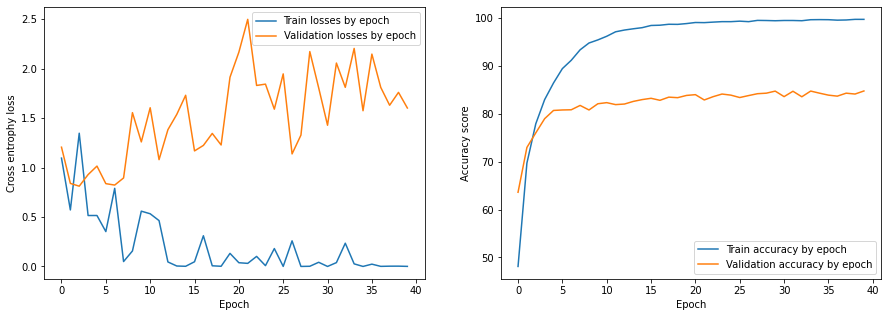

In [ ]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.3 With normalization

In [ ]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [ ]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_1,val_dataloader_1,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.3305, Train accuracy: 48.254
Loss: 1.0451, Validation accuracy: 63.07 %
Epoch [2/40], Loss: 1.1556, Train accuracy: 70.1
Loss: 1.0195, Validation accuracy: 73.84 %
Epoch [3/40], Loss: 0.4437, Train accuracy: 77.88
Loss: 0.9857, Validation accuracy: 76.59 %
Epoch [4/40], Loss: 0.7290, Train accuracy: 83.074
Loss: 1.1725, Validation accuracy: 78.6 %
Epoch [5/40], Loss: 0.5819, Train accuracy: 86.564
Loss: 0.8219, Validation accuracy: 80.44 %
Epoch [6/40], Loss: 0.3292, Train accuracy: 89.53
Loss: 1.1848, Validation accuracy: 80.4 %
Epoch [7/40], Loss: 0.3960, Train accuracy: 91.516
Loss: 0.9608, Validation accuracy: 80.37 %
Epoch [8/40], Loss: 0.1651, Train accuracy: 93.138
Loss: 1.0534, Validation accuracy: 81.04 %
Epoch [9/40], Loss: 0.0721, Train accuracy: 94.584
Loss: 0.9230, Validation accuracy: 81.72 %
Epoch [10/40], Loss: 0.0728, Train accuracy: 95.732
Loss: 1.6333, Validation accuracy: 81.88 %
Epoch [11/40], Loss: 0.2938, Train accuracy: 96.29
Loss: 1.6860, 

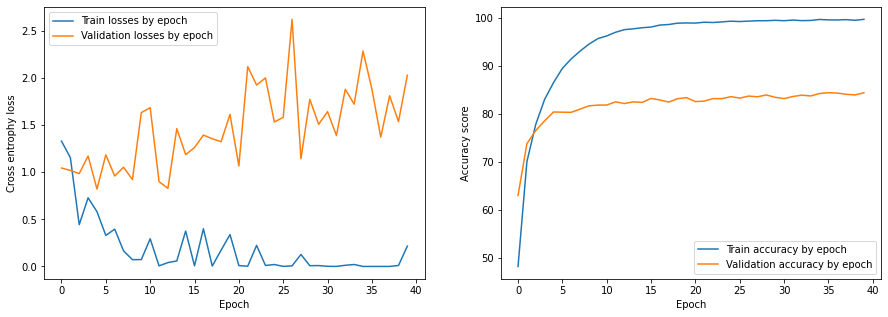

In [ ]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.4 With normalization & augmentation

In [ ]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [ ]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.5949, Train accuracy: 41.904
Loss: 1.2364, Validation accuracy: 58.43 %
Epoch [2/40], Loss: 1.2436, Train accuracy: 61.062
Loss: 0.9243, Validation accuracy: 67.09 %
Epoch [3/40], Loss: 0.7752, Train accuracy: 68.562
Loss: 1.2465, Validation accuracy: 71.22 %
Epoch [4/40], Loss: 0.5966, Train accuracy: 73.022
Loss: 0.9770, Validation accuracy: 75.05 %
Epoch [5/40], Loss: 0.4743, Train accuracy: 76.266
Loss: 0.5167, Validation accuracy: 77.62 %
Epoch [6/40], Loss: 0.4533, Train accuracy: 78.68
Loss: 0.8035, Validation accuracy: 77.52 %
Epoch [7/40], Loss: 0.2875, Train accuracy: 80.784
Loss: 0.4673, Validation accuracy: 79.88 %
Epoch [8/40], Loss: 0.7228, Train accuracy: 82.782
Loss: 0.4802, Validation accuracy: 80.47 %
Epoch [9/40], Loss: 0.7150, Train accuracy: 84.232
Loss: 0.7361, Validation accuracy: 81.4 %
Epoch [10/40], Loss: 0.4312, Train accuracy: 85.422
Loss: 0.6073, Validation accuracy: 81.96 %
Epoch [11/40], Loss: 0.5500, Train accuracy: 86.4
Loss: 0.911

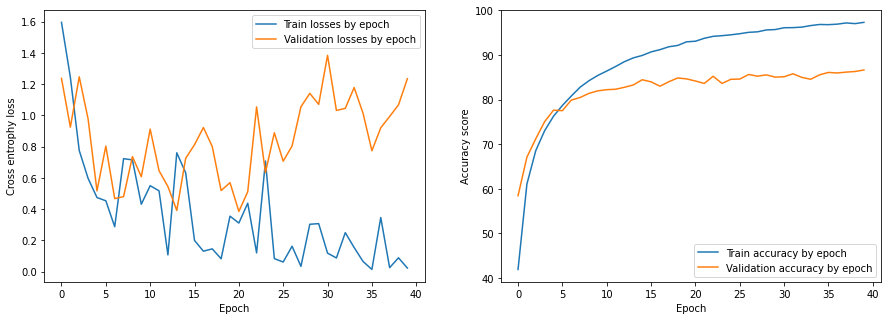

In [ ]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.5 With augmentation

In [ ]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16'

In [ ]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_3,val_dataloader_0,model,epochs,optimizer, save_path)

Epoch [1/40], Loss: 1.1863, Train accuracy: 41.53
Loss: 1.3669, Validation accuracy: 55.05 %
Epoch [2/40], Loss: 0.9308, Train accuracy: 60.724
Loss: 1.2024, Validation accuracy: 66.4 %
Epoch [3/40], Loss: 0.6970, Train accuracy: 68.726
Loss: 1.1000, Validation accuracy: 71.66 %
Epoch [4/40], Loss: 0.7621, Train accuracy: 73.264
Loss: 0.9660, Validation accuracy: 75.04 %
Epoch [5/40], Loss: 0.2750, Train accuracy: 76.366
Loss: 1.0596, Validation accuracy: 77.61 %
Epoch [6/40], Loss: 0.8071, Train accuracy: 79.186
Loss: 0.9135, Validation accuracy: 79.19 %
Epoch [7/40], Loss: 0.9425, Train accuracy: 81.04
Loss: 1.1022, Validation accuracy: 79.96 %
Epoch [8/40], Loss: 0.3931, Train accuracy: 82.952
Loss: 0.8623, Validation accuracy: 80.39 %
Epoch [9/40], Loss: 0.7980, Train accuracy: 84.332
Loss: 0.9409, Validation accuracy: 81.55 %
Epoch [10/40], Loss: 0.8682, Train accuracy: 85.636
Loss: 0.8367, Validation accuracy: 82.76 %
Epoch [11/40], Loss: 0.3068, Train accuracy: 86.602
Loss: 0.97

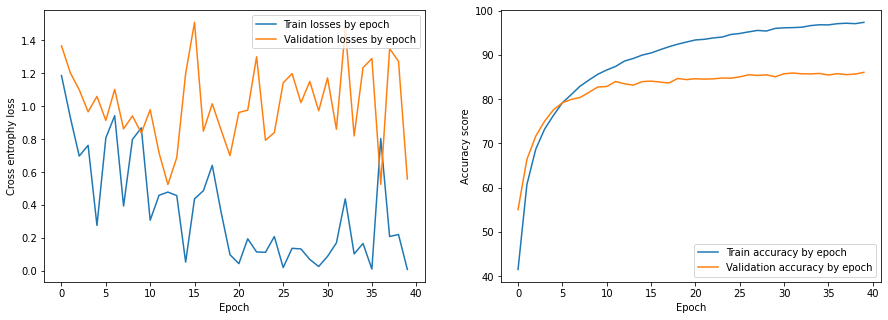

In [ ]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss)

#### 1.6 Tune the hyperparameters

In [ ]:
# Using SGD and change learning rate
lr_list = [0.1, 0.01, 0.0001, 0.001]
vgg16_train_acc=[]
vgg16_train_loss=[]
vgg16_val_acc=[]
vgg16_val_loss=[]

for lr in lr_list:
  print(f"=========== lr = {lr} ==========")
  epochs = 60
  model = VGG16(10).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
  save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16/SGD'
  train_acc, train_loss, val_acc, val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)
  vgg16_train_acc.append(train_acc)
  vgg16_train_loss.append(train_loss)
  vgg16_val_acc.append(val_acc)
  vgg16_val_loss.append(val_loss)

=========== lr = 0.1 ==========
Epoch [1/60], Training loss: 1.8660, Train accuracy: 12.962
Validation loss: 2.0207, Validation accuracy: 18.58 %
Epoch [2/60], Training loss: 1.8737, Train accuracy: 20.046
Validation loss: 1.7407, Validation accuracy: 23.54 %
Epoch [3/60], Training loss: 1.8150, Train accuracy: 24.634
Validation loss: 1.8483, Validation accuracy: 27.3 %
Epoch [4/60], Training loss: 1.9175, Train accuracy: 28.732
Validation loss: 1.8787, Validation accuracy: 33.28 %
Epoch [5/60], Training loss: 1.6514, Train accuracy: 31.796
Validation loss: 1.8471, Validation accuracy: 34.53 %
Epoch [6/60], Training loss: 2.0852, Train accuracy: 34.526
Validation loss: 2.1869, Validation accuracy: 37.42 %
Epoch [7/60], Training loss: 1.8900, Train accuracy: 38.164
Validation loss: 1.8881, Validation accuracy: 39.24 %
Epoch [8/60], Training loss: 2.2342, Train accuracy: 40.696
Validation loss: 1.5561, Validation accuracy: 43.3 %
Epoch [9/60], Training loss: 1.6381, Train accuracy: 43.50

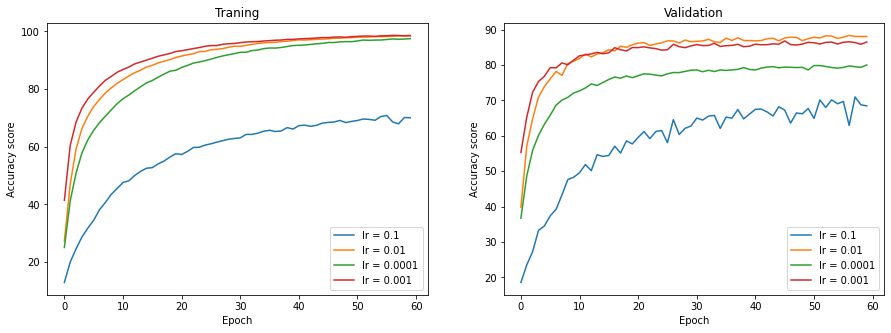

In [ ]:
# Accuracy comparision among the learning rates
plot_acc_lr(epochs,lr_list,vgg16_train_acc,vgg16_val_acc)

In [ ]:
# Using Adam and change learning rate
lr_list = [0.1, 0.01, 0.0001, 0.001]
vgg16_train_acc=[]
vgg16_train_loss=[]
vgg16_val_acc=[]
vgg16_val_loss=[]

for lr in lr_list:
  print(f"=========== lr = {lr} ==========")
  epochs = 60
  model = VGG16(10).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16/Adam'
  train_acc, train_loss, val_acc, val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)
  vgg16_train_acc.append(train_acc)
  vgg16_train_loss.append(train_loss)
  vgg16_val_acc.append(val_acc)
  vgg16_val_loss.append(val_loss)

=========== lr = 0.1 ==========
Epoch [1/60], Training loss: 2.3555, Train accuracy: 10.138
Validation loss: 2.3131, Validation accuracy: 10.0 %
Epoch [2/60], Training loss: 2.2787, Train accuracy: 10.044
Validation loss: 3.8356, Validation accuracy: 10.09 %
Epoch [3/60], Training loss: 2.3051, Train accuracy: 10.04
Validation loss: 2.3560, Validation accuracy: 9.99 %
Epoch [4/60], Training loss: 2.2991, Train accuracy: 9.758
Validation loss: 2.3920, Validation accuracy: 9.99 %
Epoch [5/60], Training loss: 2.3377, Train accuracy: 10.152
Validation loss: 2.2825, Validation accuracy: 10.0 %
Epoch [6/60], Training loss: 2.2696, Train accuracy: 10.084
Validation loss: 2.2951, Validation accuracy: 10.0 %
Epoch [7/60], Training loss: 2.2986, Train accuracy: 9.924
Validation loss: 2.2690, Validation accuracy: 10.0 %
Epoch [8/60], Training loss: 2.5002, Train accuracy: 10.092
Validation loss: 2.3658, Validation accuracy: 10.0 %
Epoch [9/60], Training loss: 2.3265, Train accuracy: 9.918
Validat

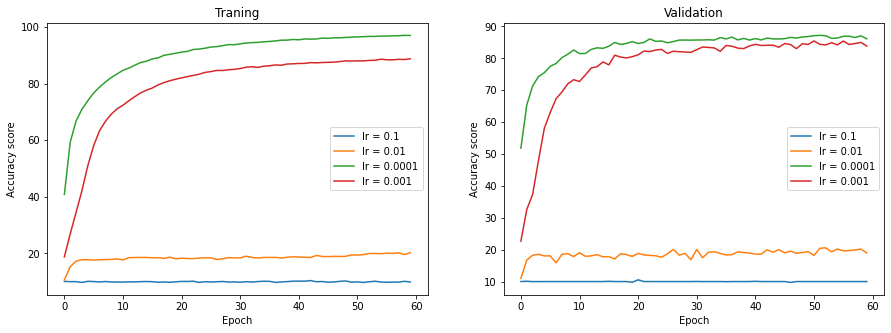

In [ ]:
# Accuracy comparision among the learning rates
plot_acc_lr(epochs,lr_list,vgg16_train_acc,vgg16_val_acc)

#### 1.7 Get the best model and examine cnn layers

In [ ]:
# Define model parameters
lr = 0.01
epochs = 53
model = VGG16(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16/SGD'

In [ ]:
# Train the model
vgg16_train_acc, vgg16_train_loss, vgg16_val_acc, vgg16_val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)

Epoch [1/53], Training loss: 1.6854, Train accuracy: 33.232
Validation loss: 1.6307, Validation accuracy: 43.43 %
Epoch [2/53], Training loss: 0.7708, Train accuracy: 51.274
Validation loss: 1.4188, Validation accuracy: 58.88 %
Epoch [3/53], Training loss: 1.1852, Train accuracy: 62.13
Validation loss: 1.2936, Validation accuracy: 66.3 %
Epoch [4/53], Training loss: 1.6640, Train accuracy: 67.2
Validation loss: 1.1264, Validation accuracy: 71.45 %
Epoch [5/53], Training loss: 0.7518, Train accuracy: 71.25
Validation loss: 0.7398, Validation accuracy: 73.94 %
Epoch [6/53], Training loss: 1.8373, Train accuracy: 74.038
Validation loss: 0.7831, Validation accuracy: 75.21 %
Epoch [7/53], Training loss: 0.9151, Train accuracy: 76.376
Validation loss: 1.0581, Validation accuracy: 78.64 %
Epoch [8/53], Training loss: 1.1869, Train accuracy: 78.802
Validation loss: 1.2297, Validation accuracy: 78.97 %
Epoch [9/53], Training loss: 0.4784, Train accuracy: 80.37
Validation loss: 0.9095, Validatio

In [ ]:
# Load model
model = VGG16(10).to(device)
model.load_state_dict(torch.load('gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG16/SGD/53epoch.pt'))
print(model)

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [ ]:
model_children = list(model.children())
model_children[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [ ]:
# Extract convolution layers
model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0

for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            if type(model_children[i][j]) == nn.Conv2d:
                counter+=1
                model_weights.append(model_children[i][j].weight)
                conv_layers.append(model_children[i][j])

print(f"Total convolution layers: {counter}")
print(conv_layers)

Total convolution layers: 13
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


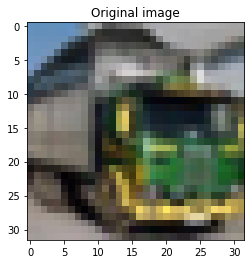

In [ ]:
# Pick an image to view
image = trainset_2.data[14]
plt.imshow(image)
plt.title("Original image")
image = transform_train_2(image)
image = image.to(device)

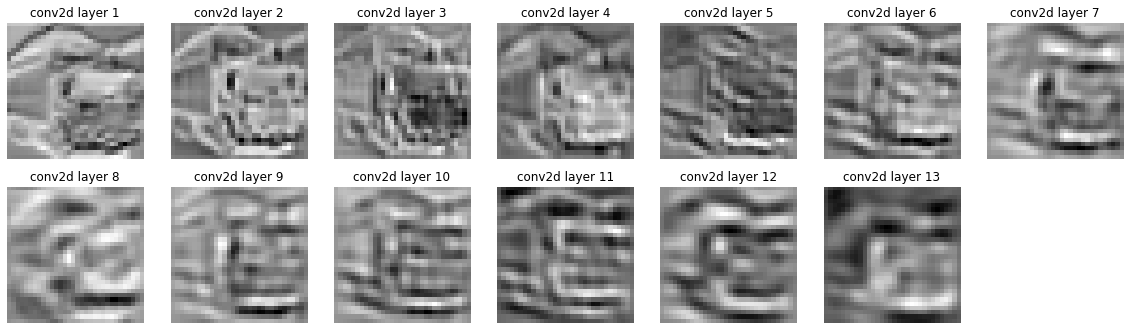

In [ ]:
# Generate feature maps
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

# Convert 3d to 2d, sum same element of every channel
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

# Visualize feature maps
fig = plt.figure(figsize=(20, 6))
fig.subplots_adjust(hspace=0.01, wspace=0.2)
count = 0
for i in range(len(processed)):
    count = count + 1
    a = fig.add_subplot(2, 7, i+1)
    imgplot = plt.imshow(processed[i],cmap="gray")
    a.axis("off")
    a.set_title(f"conv2d layer {count}")


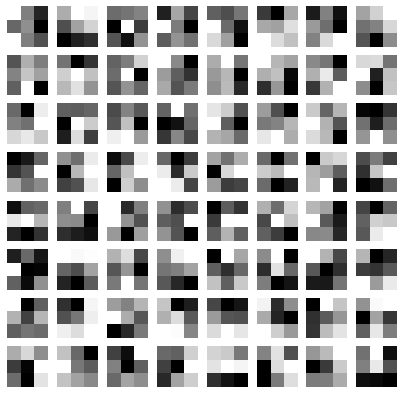

In [ ]:
# Visualize the first conv layer filters
plt.figure(figsize=(7, 7))
count = 0
for i, filter in enumerate(model_weights[0]):
    count = count + 1
    plt.subplot(8, 8, i+1) # (3, 3) because in 1st conv2d, we have 3x3 filters and total of 64 output channels
    plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

torch.Size([64, 32, 32])
Layer 1 feature maps...


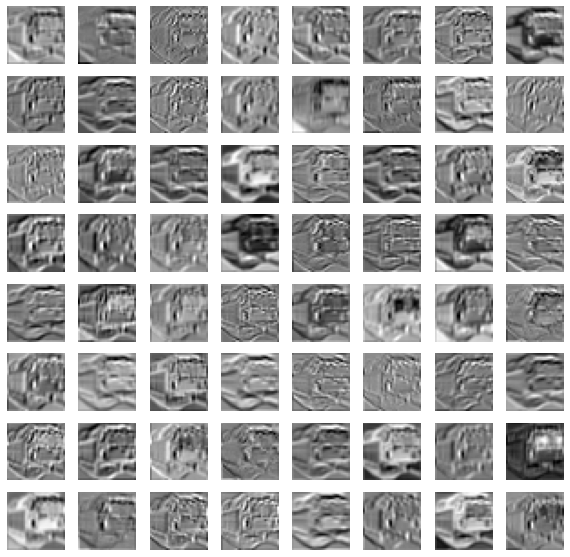

In [ ]:
# Use the same image to analyze
image = trainset_2.data[14]
image = transform_train_2(image)
image = image.to(device)
# Pass the image through all the layers
results = [conv_layers[0](image)]
for i in range(1, len(conv_layers)):
    # Pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# Make a copy of the 'results'
outputs = results

# Visualize 64 features of conv layer 1
plt.figure(figsize=(10, 10))
layer_viz = outputs[0]
layer_viz = layer_viz.data
print(layer_viz.size())
for i, filter in enumerate(layer_viz):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter.cpu(), cmap='gray')
    plt.axis("off")
print(f"Layer 1 feature maps...")
plt.show()

### **2. VGG13**

#### 2.1 Architecture

In [18]:
# Define VGG16 network
class VGG13(nn.Module):
    def __init__(self,num_classes=10):
        super(VGG13, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*2*512, 500), # change to adapt to 32x32 image input
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(500, 500),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(500, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out) # 16x16
        out = self.layer3(out)
        out = self.layer4(out) # 8x8
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out) # 4x4
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out) # 2x2
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### 2.2. Basic transformation

In [19]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG13(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG_update'

In [20]:
# Train the model
vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss = train_validate_model(train_dataloader_0,val_dataloader_0,model,epochs,optimizer, save_path)

Epoch [1/40], Training loss: 1.4988, Train accuracy: 47.546
Validation loss: 1.0143, Validation accuracy: 62.69 %
Epoch [2/40], Training loss: 0.4181, Train accuracy: 68.286
Validation loss: 1.0123, Validation accuracy: 72.34 %
Epoch [3/40], Training loss: 0.3393, Train accuracy: 76.578
Validation loss: 0.7753, Validation accuracy: 76.74 %
Epoch [4/40], Training loss: 0.6189, Train accuracy: 81.498
Validation loss: 0.7494, Validation accuracy: 78.52 %
Epoch [5/40], Training loss: 0.2219, Train accuracy: 85.002
Validation loss: 0.9214, Validation accuracy: 80.36 %
Epoch [6/40], Training loss: 0.2263, Train accuracy: 88.062
Validation loss: 0.7604, Validation accuracy: 80.98 %
Epoch [7/40], Training loss: 0.3040, Train accuracy: 90.172
Validation loss: 0.9405, Validation accuracy: 81.0 %
Epoch [8/40], Training loss: 0.2259, Train accuracy: 91.788
Validation loss: 0.5692, Validation accuracy: 81.99 %
Epoch [9/40], Training loss: 0.1149, Train accuracy: 93.432
Validation loss: 0.8387, Vali

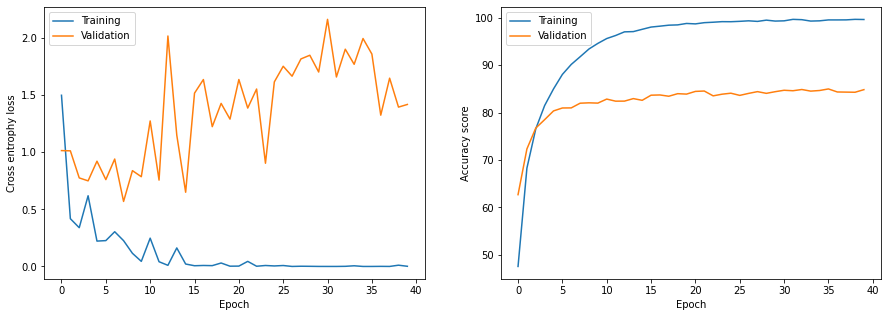

In [21]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss)

#### 2.3 With normalization

In [22]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG13(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG_update'

In [23]:
# Train the model
vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss = train_validate_model(train_dataloader_1,val_dataloader_1,model,epochs,optimizer, save_path)

Epoch [1/40], Training loss: 0.7858, Train accuracy: 47.314
Validation loss: 1.2110, Validation accuracy: 61.67 %
Epoch [2/40], Training loss: 0.6240, Train accuracy: 68.592
Validation loss: 0.8758, Validation accuracy: 72.12 %
Epoch [3/40], Training loss: 0.9380, Train accuracy: 76.826
Validation loss: 0.7361, Validation accuracy: 76.63 %
Epoch [4/40], Training loss: 0.3875, Train accuracy: 81.608
Validation loss: 0.9723, Validation accuracy: 78.17 %
Epoch [5/40], Training loss: 0.5147, Train accuracy: 85.19
Validation loss: 0.6299, Validation accuracy: 79.75 %
Epoch [6/40], Training loss: 0.3940, Train accuracy: 87.96
Validation loss: 0.6943, Validation accuracy: 80.94 %
Epoch [7/40], Training loss: 0.5028, Train accuracy: 90.044
Validation loss: 0.9314, Validation accuracy: 80.19 %
Epoch [8/40], Training loss: 0.6301, Train accuracy: 91.94
Validation loss: 1.2467, Validation accuracy: 82.29 %
Epoch [9/40], Training loss: 0.0582, Train accuracy: 93.346
Validation loss: 0.9423, Valida

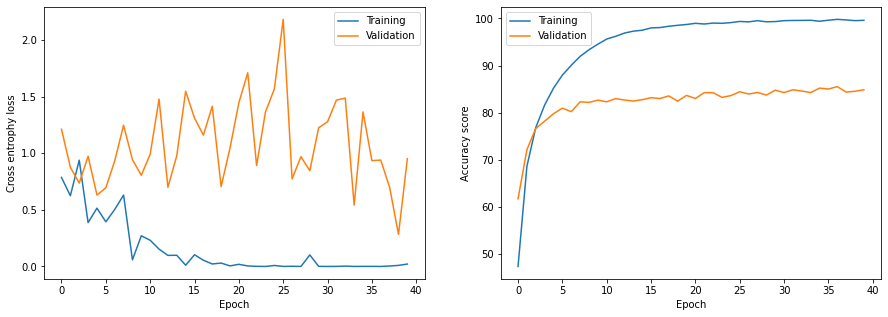

In [24]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss)

#### 2.4 With normalization & augmentation

In [25]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG13(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG_update'

In [26]:
# Train the model
vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)

Epoch [1/40], Training loss: 1.3150, Train accuracy: 41.75
Validation loss: 1.5638, Validation accuracy: 56.26 %
Epoch [2/40], Training loss: 0.8392, Train accuracy: 60.628
Validation loss: 1.2226, Validation accuracy: 66.65 %
Epoch [3/40], Training loss: 0.4705, Train accuracy: 68.378
Validation loss: 1.1196, Validation accuracy: 72.2 %
Epoch [4/40], Training loss: 1.1187, Train accuracy: 72.692
Validation loss: 0.9512, Validation accuracy: 74.2 %
Epoch [5/40], Training loss: 0.7573, Train accuracy: 75.762
Validation loss: 0.7405, Validation accuracy: 77.54 %
Epoch [6/40], Training loss: 0.9104, Train accuracy: 78.34
Validation loss: 0.8488, Validation accuracy: 78.8 %
Epoch [7/40], Training loss: 1.0127, Train accuracy: 79.93
Validation loss: 0.8059, Validation accuracy: 79.61 %
Epoch [8/40], Training loss: 0.4454, Train accuracy: 82.03
Validation loss: 0.8748, Validation accuracy: 79.84 %
Epoch [9/40], Training loss: 0.2699, Train accuracy: 83.25
Validation loss: 0.9990, Validation 

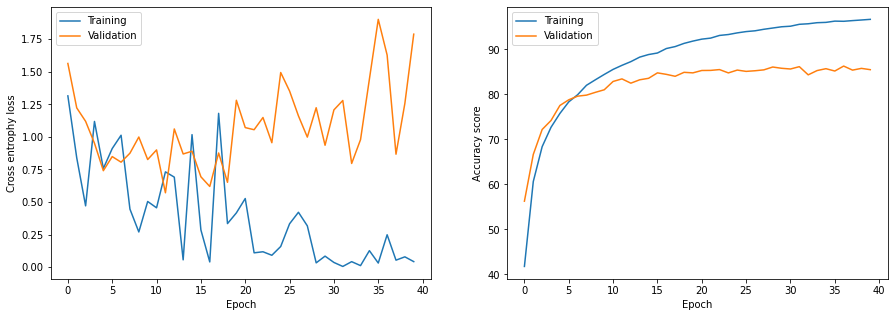

In [27]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss)

#### 2.5 With augmentation

In [28]:
# Define model parameters
lr = 0.001
epochs = 40
model = VGG13(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG_update'

In [29]:
# Train the model
vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss = train_validate_model(train_dataloader_3,val_dataloader_0,model,epochs,optimizer, save_path)

Epoch [1/40], Training loss: 0.9523, Train accuracy: 40.824
Validation loss: 1.1962, Validation accuracy: 55.71 %
Epoch [2/40], Training loss: 0.9558, Train accuracy: 60.692
Validation loss: 1.1242, Validation accuracy: 65.56 %
Epoch [3/40], Training loss: 0.3685, Train accuracy: 68.442
Validation loss: 0.9580, Validation accuracy: 72.55 %
Epoch [4/40], Training loss: 0.7993, Train accuracy: 72.73
Validation loss: 0.5453, Validation accuracy: 75.2 %
Epoch [5/40], Training loss: 0.9216, Train accuracy: 75.988
Validation loss: 0.6630, Validation accuracy: 77.58 %
Epoch [6/40], Training loss: 0.4787, Train accuracy: 78.652
Validation loss: 0.5651, Validation accuracy: 79.2 %
Epoch [7/40], Training loss: 0.2802, Train accuracy: 80.486
Validation loss: 0.5058, Validation accuracy: 79.85 %
Epoch [8/40], Training loss: 0.6645, Train accuracy: 82.128
Validation loss: 0.3748, Validation accuracy: 80.74 %
Epoch [9/40], Training loss: 0.8943, Train accuracy: 83.316
Validation loss: 0.8126, Valida

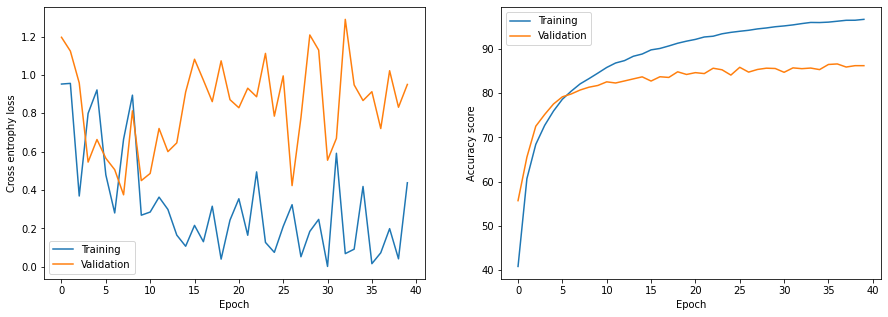

In [30]:
# Plot loss and accuracy plot
epoch_list = []
for epoch in range(epochs):
  epoch_list.append(epoch)

plot_acc_loss(epoch_list, vgg13_u_train_acc, vgg13_train_loss, vgg13_val_acc, vgg13_val_loss)

#### 2.6 Tune the hyperparameters

In [31]:
# Using SGD and change learning rate
lr_list = [0.1, 0.01, 0.0001, 0.001]
vgg13_train_acc=[]
vgg13_train_loss=[]
vgg13_val_acc=[]
vgg13_val_loss=[]

for lr in lr_list:
  print(f"=========== lr = {lr} ==========")
  epochs = 60
  model = VGG13(10).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
  save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG_update/SGD'
  train_acc, train_loss, val_acc, val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)
  vgg13_train_acc.append(train_acc)
  vgg13_train_loss.append(train_loss)
  vgg13_val_acc.append(val_acc)
  vgg13_val_loss.append(val_loss)

=========== lr = 0.1 ==========
Epoch [1/60], Training loss: 2.3010, Train accuracy: 10.138
Validation loss: 2.3149, Validation accuracy: 10.0 %
Epoch [2/60], Training loss: 2.2671, Train accuracy: 9.84
Validation loss: 2.3155, Validation accuracy: 10.0 %
Epoch [3/60], Training loss: 2.3077, Train accuracy: 9.922
Validation loss: 2.3927, Validation accuracy: 10.0 %
Epoch [4/60], Training loss: 2.3266, Train accuracy: 9.912
Validation loss: 2.3388, Validation accuracy: 10.0 %
Epoch [5/60], Training loss: 2.3075, Train accuracy: 10.012
Validation loss: 2.2779, Validation accuracy: 10.0 %
Epoch [6/60], Training loss: 2.3373, Train accuracy: 10.004
Validation loss: 2.3844, Validation accuracy: 10.0 %
Epoch [7/60], Training loss: 2.3531, Train accuracy: 10.036
Validation loss: 2.2999, Validation accuracy: 10.0 %
Epoch [8/60], Training loss: 2.3454, Train accuracy: 9.838
Validation loss: 2.3509, Validation accuracy: 10.0 %
Epoch [9/60], Training loss: 2.2969, Train accuracy: 10.204
Validatio

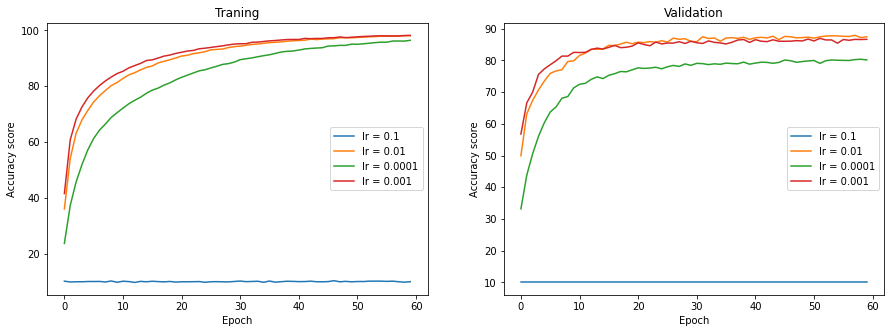

In [32]:
# Accuracy comparision among the learning rates
plot_acc_lr(epochs,lr_list,vgg13_train_acc,vgg13_val_acc)

In [ ]:
# Using Adam and change learning rate
lr_list = [0.1, 0.01, 0.0001, 0.001]
vgg13_train_acc=[]
vgg13_train_loss=[]
vgg13_val_acc=[]
vgg13_val_loss=[]

for lr in lr_list:
  print(f"=========== lr = {lr} ==========")
  epochs = 60
  model = VGG13(10).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  save_path = 'gdrive/MyDrive/Portfolio/CIFAR-10 image classification/VGG_update/Adam'
  train_acc, train_loss, val_acc, val_loss = train_validate_model(train_dataloader_2,val_dataloader_1,model,epochs,optimizer, save_path)
  vgg13_train_acc.append(train_acc)
  vgg13_train_loss.append(train_loss)
  vgg13_val_acc.append(val_acc)
  vgg13_val_loss.append(val_loss)

In [ ]:
# Accuracy comparision among the learning rates
plot_acc_lr(epochs,lr_list,vgg13_train_acc,vgg13_val_acc)

#### 2.7 Get the best model and examine cnn layers

### **3. Resnet**

#### 3.1 Architecture